In [1]:
#%% Mount Google drive if you use colab for save and load files
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/02_Surrogate/FOPDT/SISO/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

# Install(if it hasn't been) and Import GEKKO package
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

Not running on Colab


In [2]:
# from gekko import GEKKO
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Reshape, Conv1DTranspose, Conv2DTranspose

from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback

In [3]:
data = pd.read_pickle(path + 'MIMO_open_loop_data_6000.pkl')
data = pd.DataFrame(np.array(data).T, columns=['u1', 'u2', 'y1', 'y2'])

In [4]:
data["y1"][1:] = data["y1"][0:-1]
data["y2"][1:] = data["y2"][0:-1]

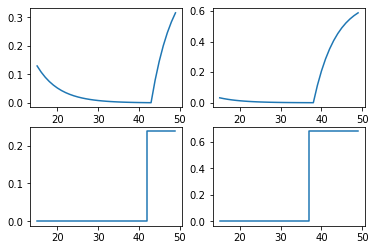

In [5]:
plt.figure(0)
plt.subplot(2,2,1)
plt.plot(data["y1"][15:50])
plt.subplot(2,2,2)
plt.plot(data["y2"][15:50])
plt.subplot(2,2,3)
plt.plot(data["u1"][15:50], drawstyle='steps')
plt.subplot(2,2,4)
plt.plot(data["u2"][15:50], drawstyle='steps')

plt.show()

## 4. Train LSTM Network

In [6]:
window = 5
P = 10

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
# s1.data_min_=[0,0,0,0]
# s1.data_max_=[5,5,5,5]
Xs = s1.fit_transform(data[['u1', 'u2', 'y1', 'y2']])
s2 = MinMaxScaler(feature_range=(-1,1))
# s2.data_min_=[0,0,0,0]
# s2.data_max_=[10,10,10,10]
Ys = s2.fit_transform(data[['y1', 'y2']])

In [7]:
Ys.shape, Xs.shape

((6000, 2), (6000, 4))

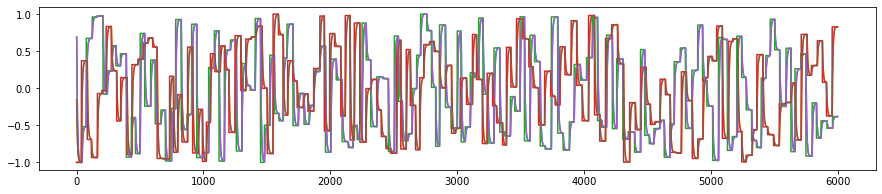

In [8]:
plt.figure(figsize=[15,3])
plt.plot(Ys)
plt.plot(Xs)

In [9]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window
model_params['P'] = P # prediction horizon

dump(model_params, open(path + 'model_param_MIMO.pkl', 'wb'))


In [10]:
nstep = Xs.shape[0]
val_ratio = 0.5
cut_index = int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

3000


## Preparing training data for simultaneous **multi-step** prediction
X_train $\in$ $\mathbb{R}$ $^{\text{Batch}\: \times \:(\text{window + P})\: \times\: \text{Nvariables}}$  
Y_train $\in$ $\mathbb{R}$ $^{\text{Batch}\: \times \:\text{P}\: \times\: \text{Nvariables}}$  


In [11]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)-P):
    X_train.append(Xs_train[i-window:i+P,:])
    Y_train.append(Ys_train[i:i+P])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)-P):
    X_val.append(Xs_val[i-window:i+P,:])
    Y_val.append(Ys_val[i:i+P])

In [12]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

## Replacing outputs in the prediction horizon ($\text y_{k+i}$) with the latest measured value ($\text y_k$)  , where, $i = 1, 2, ... ,\text P$

In [13]:
for i in range(0, len(X_train)):
    X_train[i][window:,2] = X_train[i][window-1,2]
    X_train[i][window:,3] = X_train[i][window-1,3]

for i in range(0, len(X_val)):
    X_val[i][window:,2] = X_val[i][window-1,2]
    X_val[i][window:,3] = X_val[i][window-1,3]

In [14]:
# Demension of training data set
# Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]*Y_train.shape[2]))
# Y_val = np.reshape(Y_val, (Y_val.shape[0], Y_val.shape[1]*Y_val.shape[2]))
np.shape(X_train), np.shape(Y_train)

((2985, 15, 4), (2985, 10, 2))

In [15]:
X_train[15], Y_train[15]

(array([[-1.        , -1.        , -0.86895212, -0.93534688],
        [-1.        , -1.        , -0.89092674, -0.94628755],
        [-1.        , -1.        , -0.90923892, -0.95540477],
        [-1.        , -1.        , -0.92449907, -0.96300246],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387],
        [-1.        , -1.        , -0.93721586, -0.96933387]]),
 array([[-0.94781319, -0.97461004],
        [-0.9566443 , -0.9790068

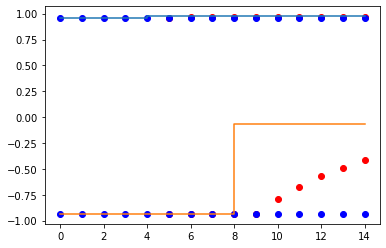

In [16]:
i = 155
t = np.linspace(0, 14, 15)
plt.plot(t[5:],Y_train[i],'ro')
plt.plot(t, X_train[i][:,2],'bo')
plt.step(t, X_train[i][:,0])
plt.plot(t, X_train[i][:,3],'bo')
plt.step(t, X_train[i][:,1])

In [17]:
Y_train[160]

array([[ 0.96928055, -0.79124507],
       [ 0.97023552, -0.67123047],
       [ 0.97103133, -0.5712183 ],
       [ 0.9716945 , -0.48787483],
       [ 0.97224715, -0.41842193],
       [ 0.97270768, -0.36054452],
       [ 0.97309146, -0.31231335],
       [ 0.97341128, -0.2721207 ],
       [ 0.97367779, -0.23862683],
       [ 0.97389989, -0.21071527]])

In [18]:
X_train[160]

array([[ 0.97494799, -0.93438002,  0.96075275, -0.93521253],
       [ 0.97494799, -0.93438002,  0.96312902, -0.93522864],
       [ 0.97494799, -0.93438002,  0.96510925, -0.93524207],
       [ 0.97494799, -0.93438002,  0.96675944, -0.93525327],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259],
       [ 0.97494799, -0.0710398 ,  0.96813459, -0.93526259]])

In [19]:
# # Initialize LSTM model


model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(tf.keras.layers.Flatten())
model_lstm.add(Dense(units=Y_train.shape[1]*Y_train.shape[2], activation='linear'))
model_lstm.add(Reshape((Y_train.shape[1], Y_train.shape[2])))
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

Metal device set to: Apple M1 Pro


2022-05-27 13:44:34.679061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-27 13:44:34.679353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
model_lstm.summary()
# Fit (and time) LSTM model
t0 = time.time()
result_lstm = model_lstm.fit(X_train, Y_train, epochs = 300, batch_size = 32,\
                             callbacks=[es_lstm, TqdmCallback(verbose=1)],\
                             verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

# model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           42000     
                                                                 
 dropout (Dropout)           (None, 15, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 15, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-05-27 13:44:35.300459: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-27 13:44:37.099789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:44:37.563475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:44:37.661226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:44:37.725134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:44:37.836146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:44:37.973662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

Epoch 114: early stopping
Runtime: 361.79 s


In [21]:
#%% Save LSTM model file
model_lstm.save('MPC_MIMO_FOPDT_multistep_LSTM_6000.h5')

## 2. Transformer

In [22]:
n_feature = X_train.shape[2]
n_label = Y_train.shape[1]

encoder_input = tf.keras.layers.Input(shape=(window+P, n_feature))
xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(xl,xl)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.Flatten()(xl)
xl = tf.keras.layers.Dense(units=Y_train.shape[1]*Y_train.shape[2], activation=None)(xl)
yl = tf.keras.layers.Reshape((Y_train.shape[1], Y_train.shape[2]))(xl)

model_trans = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")
model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

# Allow for early exit
es_trans = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

t0 = time.time()
result_trans = model_trans.fit(X_train,Y_train,epochs=300,batch_size=32, \
                               callbacks=[es_trans, TqdmCallback(verbose=1)], \
                               verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()

print('Runtime: %.2f s' %(t1-t0))

model_trans.summary()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-05-27 13:50:37.647026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:50:40.903301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 141: early stopping
Runtime: 522.03 s
Model: "mhl"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 4)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 15, 4)       384         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 15, 4)       0           ['multi_head_attention[0][0]',   
 da)                                                              'input_1[0][0]']                
                                                    

In [23]:
#%% Save Transformer model file
model_trans.save('MPC_MIMO_FOPDT_multistep_Trans_6000.h5')

Text(0.5, 0, 'Epochs')

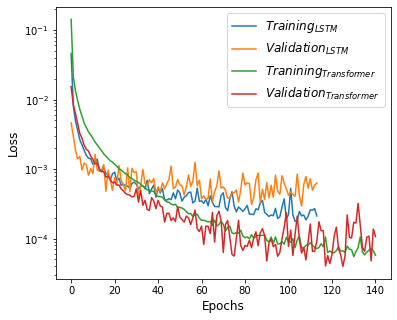

In [24]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(result_lstm.history['loss'],label='$Training_{LSTM}$')
plt.semilogy(result_lstm.history['val_loss'],label='$Validation_{LSTM}$')
plt.semilogy(result_trans.history['loss'],label='$Tranining_{Transformer}$')
plt.semilogy(result_trans.history['val_loss'],label='$Validation_{Transformer}$')
plt.legend(loc=1, fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

# plt.savefig(path + 'Loss_surrogate_SISO_FOPDT_multistep.eps', format='eps')

## 5. Using measured values to predict next step

### LSTM

In [25]:
# # Load NN Models
model_lstm = load_model('MPC_MIMO_FOPDT_multistep_LSTM_6000.h5')
model_trans = load_model('MPC_MIMO_FOPDT_multistep_Trans_6000.h5')

In [26]:
# Verify the fit of the model
Yp_train_lstm = model_lstm.predict(X_train)
Yp_val_lstm = model_lstm.predict(X_val)

# un-scale outputs
# Yu_train_lstm = s2.inverse_transform(Yp_train_lstm) # model prediction
# Ym_train = s2.inverse_transform(Y_train) # measured value

# Yu_val_lstm = s2.inverse_transform(Yp_val_lstm) # model prediction
# Ym_val = s2.inverse_transform(Y_val) # measured value


# Verify the fit of the model
Yp_train_trans = model_trans.predict(X_train)
Yp_val_trans = model_trans.predict(X_val)

# un-scale outputs
# Yu_train_trans = s2.inverse_transform(Yp_train_trans) # model prediction
# Ym_train = s2.inverse_transform(Y_train) # measured value

# Yu_val_trans = s2.inverse_transform(Yp_val_trans) # model prediction
# Ym_val = s2.inverse_transform(Y_val) # measured value




# plt.figure(0, figsize=(30,4))
# plt.subplot(1,2,1)
# plt.plot(data.index[window:cut_index-P],Ym_train[:,0],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,0],'r-',label='LSTM')
# plt.plot(data.index[window:cut_index-P],Yu_train_trans[:,0],'g--',label='Transformer')

# plt.title('Training')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(data.index[cut_index+window:-P],Ym_val[:,0],'b-',label='Measured')
# plt.plot(data.index[cut_index+window:-P],Yu_val_lstm[:,0],'r-',label='LSTM')
# plt.plot(data.index[cut_index+window:-P],Yu_val_trans[:,0],'g--',label='Transformer')
# plt.title('Validation')
# plt.legend()

# plt.figure(1, figsize=(30,4))
# plt.subplot(1,2,1)
# plt.plot(data.index[window:cut_index-P],Ym_train[:,4],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,4],'r-',label='LSTM')
# plt.plot(data.index[window:cut_index-P],Yu_train_trans[:,4],'g--',label='Transformer')
# plt.title('Training')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(data.index[cut_index+window:-P],Ym_val[:,4],'b-',label='Measured')
# plt.plot(data.index[cut_index+window:-P],Yu_val_lstm[:,4],'r-',label='LSTM')
# plt.plot(data.index[cut_index+window:-P],Yu_val_trans[:,4],'g--',label='Transformer')
# plt.title('Validation')
# plt.legend()



2022-05-27 13:59:20.406772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:59:20.564596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:59:20.613225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:59:20.658298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-27 13:59:22.440198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [27]:
Y_train.shape

(2985, 10, 2)

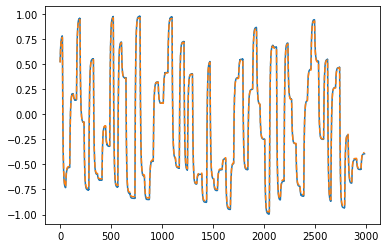

In [28]:
plt.plot(Yp_val_trans[:,5,0])
plt.plot(Y_val[:,5,0],"--")

In [29]:
a = Yp_val_trans.reshape(Yp_val_trans.shape[0], Yp_val_trans.shape[2], Yp_val_trans.shape[1])
b = Y_val.reshape(Y_val.shape[0], Y_val.shape[2], Y_val.shape[1])

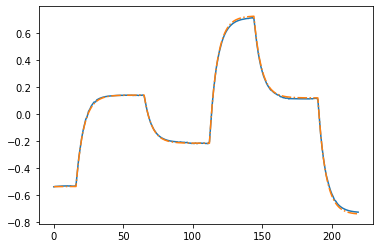

In [30]:
plt.plot(a[:220, 0, 9])
plt.plot(b[:220, 0, 9], '-.')

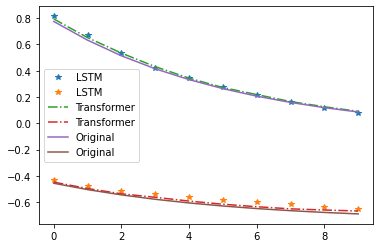

In [31]:
plt.plot(Yp_val_lstm[200], '*', label='LSTM')
plt.plot(Yp_val_trans[200], '-.', label='Transformer')

plt.plot(Y_val[200], label='Original')
plt.legend()

In [32]:
# plt.plot(data.index[window:cut_index-P],Ym_train[:,0],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,0],'r-',label='LSTM')
plt.figure(figsize=(30,4))
plt.plot(Ym_train[:,0], 'k-')
plt.plot(Y2, 'g--')
plt.plot(Y1,'r--',label='Transformer')



np.shape(Yu_train_trans[0:785:10])
Y1 = np.transpose(np.reshape(Yu_train_trans[0:785:10], (1,790)))
Y2 = np.transpose(np.reshape(Yu_train_lstm[0:785:10], (1,790)))
np.reshape()

NameError: name 'Ym_train' is not defined

<Figure size 2160x288 with 0 Axes>

In [ ]:
j =210
plt.subplot(2,1,1)
plt.plot(Yu_val_lstm[j], 'r--', label='LSTM Prediction')
plt.plot(Ym_val[j], label='Data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(X_val[j][window:,0], 'r-', drawstyle = 'steps')
plt.legend()